### Packages

In [1]:
from pathlib import Path
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splrep, splev
from scipy.interpolate import CubicSpline

### Preprocessed data

In [2]:
cardio_path = Path().resolve().parents[1] / "dane" / "KARDIO ZAMKNIETE"
data_path = cardio_path / "A001" / "DICOM" / "P1" / "E1" / "S1"

Multidimensional array for one series of images

In [3]:
def convert_sequence_to_array(path: Path):
    return np.stack([np.flip(dcmread(file).pixel_array) for file in data_path.iterdir()], axis=0)

In [4]:
stacked = convert_sequence_to_array(data_path)

### Image info

In [5]:
path_to_first_file = next(data_path.glob("*"))
dcm_file = dcmread(path_to_first_file)
print(f"Number of images: {stacked.shape[0]}")
print(f"Size of image: {stacked.shape[1]}x{stacked.shape[2]}")
print(f"Pixel size: {dcm_file.PixelSpacing} mm")
print(f"Reconstruction center: {dcm_file[(0x7005, 0x1007)].value}")
pixel_size_x = dcm_file.PixelSpacing[1]
pixel_size_y = dcm_file.PixelSpacing[0]

Number of images: 512
Size of image: 512x512
Pixel size: [0.402, 0.402] mm
Reconstruction center: [308, 216]


### Hounsfield scale

The pixel values of this CT scan are expressed in Hounsfield Units:
$$
HU(x,y) = 1000 \cdot \frac{\mu{(x,y)} - \mu_{water}}{\mu_{water}-\mu_{air}}
$$
where $\mu$ is the attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_{0}e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies 100 keV.

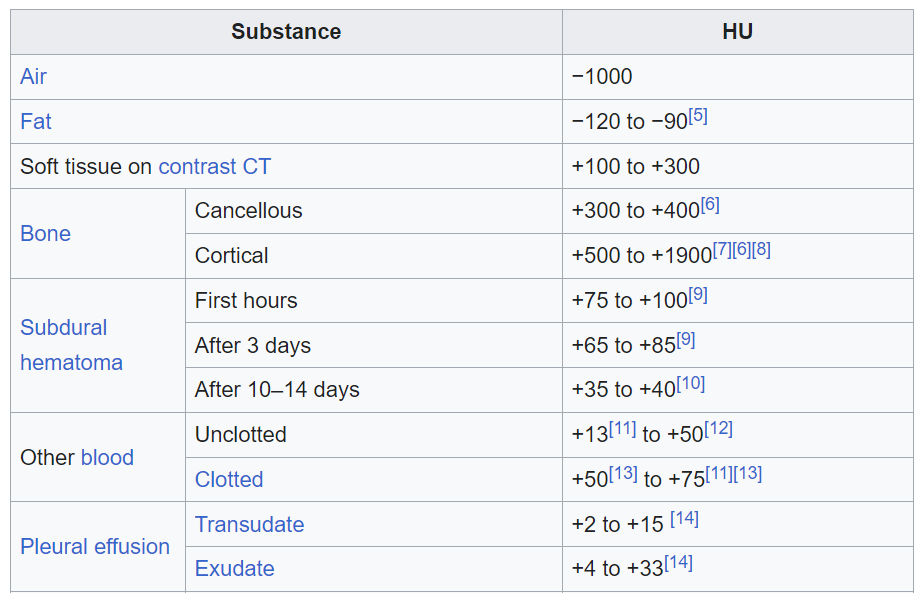

### Histogram of Hounsfield values

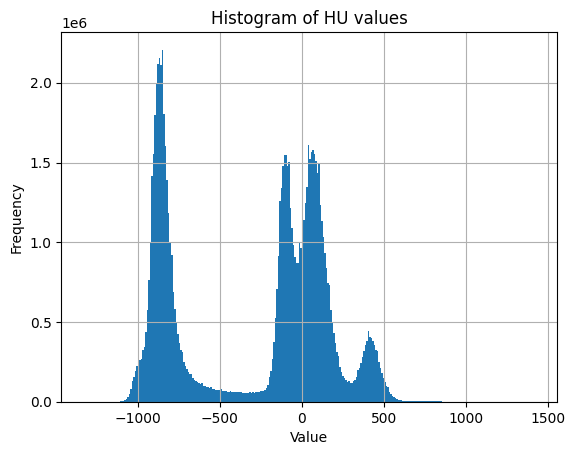

In [6]:
flattened_stacked = stacked.flatten()
flattened_filtered_stacked = flattened_stacked[flattened_stacked > -2000]
hist, bins = np.histogram(flattened_filtered_stacked, bins=300)
plt.hist(flattened_filtered_stacked, bins=300)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of HU values')
plt.grid()
plt.show()

### Noise assesment in CT
Basic concept of signal and noise:
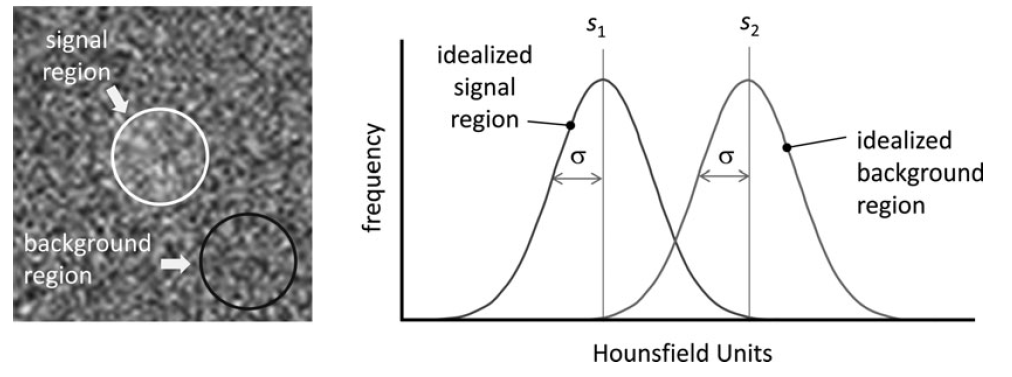
The noise distributions within the object and in the background are characterized by normal distributions defined by their standard deviations $\sigma$, with the shift between the two distributions corresponding to the signal amplitude: $|s_{1}-s_{2}|$. Although the signal-to-noise ratio is an important parameter in determining the detectability of an object, the SNR does not completely characterize noise. These two images with exactly the same noise level as measured by the standard
deviation $\sigma$ however, these two images have dramatically different appearances to the observer.
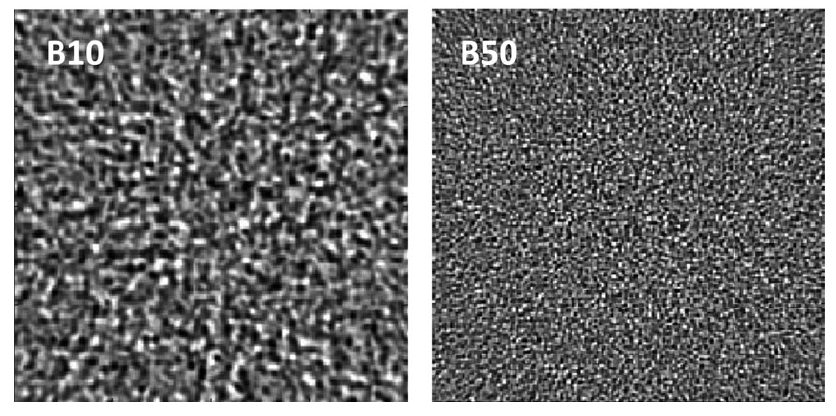
The differences between images are due to the noise texture, that is, the spatial-frequency distribution of the noise is different in these two images.  

**Noise power spectrum**  
The noise-power spectrum (NPS) is a useful measure that provides a more complete description of noise than the simple standard deviation. It describes the noise variance as a function of spatial frequency and therefore characterizes noise texture.  
**The NPS computation in CT scans** 
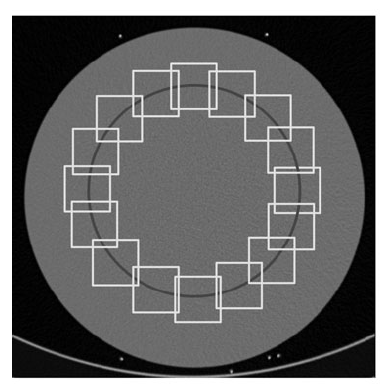
Select ROI (Region-of-Interest) sampled at a constant radius around the center of the phantom image. NPS can be calculated with the formula:
$$
NPS(f_{x},f_{y})=\frac{1}{N}\frac{\Delta_{x}\Delta_{y}}{N_{x}N_{y}}\sum_{i=1}^{N}|DFT_{2D}[I_{i}(x,y)-\bar{I_{i}}]|^{2}
$$
where:  
$N$ - the number of ROIs  
$I_{i}(x,y)$ - the signal in the $i^{th}$ ROI  
$\bar{I}$ - mean of $I_{i}(x,y)$  
$\Delta_{x}, \Delta_{y}$ - pixel size  
Result of NPS in spatial frequency $f_{x}, f_{y}$
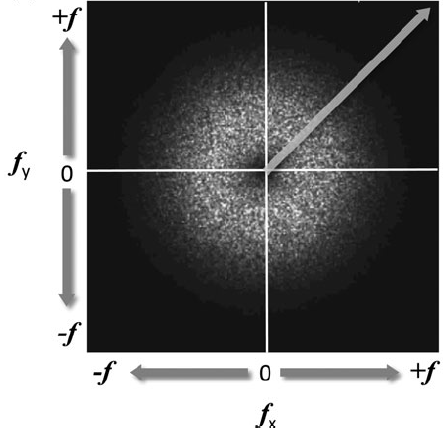  
Sigma $\sigma$ can be calculated with the formula:
$$
\sigma^{2} = \iint NPS_{2D}(f_{x}, f_{y}) df_{x}df_{y}
$$
**1D NPS**  
The $f_{x}$ and $f_{y}$ frequencies in the 2D NPS can be collapsed to a 1D radial frequency, $f_{r}$ by radially averaging using:  
$$
f_{r} = \sqrt{f_{x}^{2}+f_{y}^2}
$$
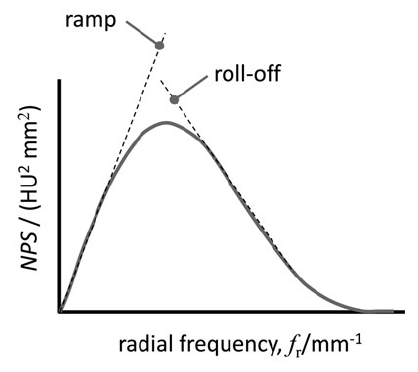
The initial positive slope of this curve results from the ramp filtering that is used in filtered-back-projection reconstruction, and the negative slope at higher spatial frequencies occurs due to the roll-off properties of the reconstruction kernel used to dampen high-frequency noise in the images.

### Input image

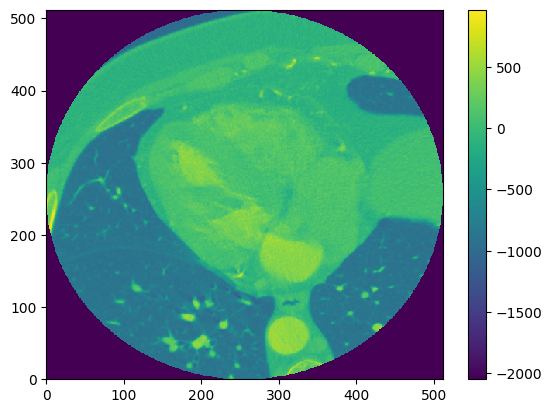

In [7]:
image = stacked[0]
plt.pcolormesh(image)
plt.colorbar();

### ROIs

In [8]:
def select_ROI_array(image, y0, x0, size, num, plot=False):
    r = np.sqrt((y0-256)**2+(x0-256)**2)
    ROI_array = []
    if plot:
        plt.pcolormesh(image)
        plt.colorbar();
        plt.title("Selected ROIs")
    for i in range(num):
        y = int(r*np.cos((i*2*np.pi)/num)) + 256
        x = int(r*np.sin((i*2*np.pi)/num)) + 256
        if plot:
            plt.gca().add_patch(Rectangle((x-size//2,y-size//2),size,size,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
        ROI_array.append(image[y-size//2:y+size//2,x-size//2:x+size//2])
    return ROI_array

N: 16 (64, 64)


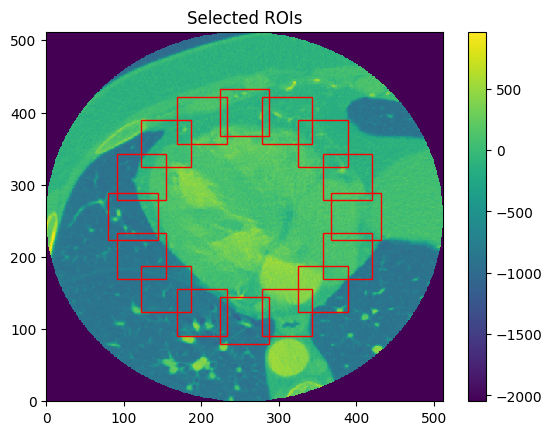

In [9]:
ROI_array = select_ROI_array(image=image, y0=400, x0=250, size=64, num=16, plot=True)
print(f"N: {len(ROI_array)} {ROI_array[0].shape}")

### NPS 2D

In [10]:
def calculate_NPS_2D(ROI_array, pixel_size_x, pixel_size_y):
    NPS_array = []
    for roi in ROI_array:
        # calculation od DFT 2D
        dft = np.fft.fft2(roi - np.mean(roi))
        # shift of FT
        shifted_dft = np.fft.fftshift(dft)
        # calcation of absolute value
        NPS_array.append(np.abs(shifted_dft)**2)
    N = len(NPS_array)
    Ly = NPS_array[0].shape[0]
    Lx = NPS_array[0].shape[1]
    return (1/N)*(1/(Lx*Ly))*(np.sum(NPS_array,axis=0)*pixel_size_x*pixel_size_y)

In [11]:
NPS = calculate_NPS_2D(ROI_array, pixel_size_x, pixel_size_y)

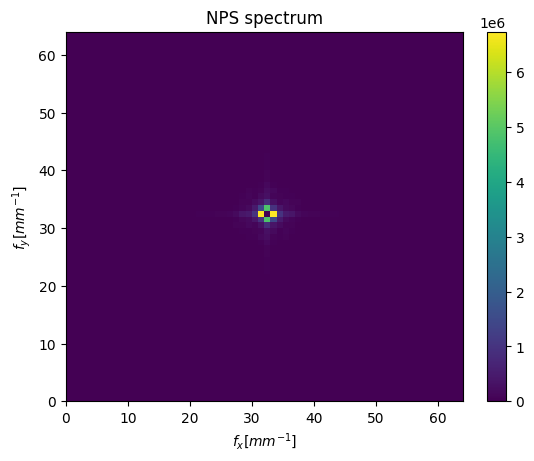

In [12]:
plt.pcolormesh(NPS)
plt.title("NPS spectrum")
plt.xlabel("$f_{x} [mm^{-1}]$")
plt.ylabel("$f_{y} [mm^{-1}]$")
plt.colorbar();

### Sigma

In [13]:
def calculate_sigma(image):
    ROI_array = select_ROI_array(image=image, y0=400, x0=250, size=64, num=16)
    NPS = calculate_NPS_2D(ROI_array, 0.402, 0.402)
    dx = 1
    dy = 1
    return np.sqrt(np.trapz(np.trapz(NPS, dx=dx, axis=1), dx=dy, axis=0)), NPS

In [14]:
sigma,NPS_2D = calculate_sigma(image)
print(f"Sigma: {sigma:.5}")

Sigma: 6907.8


### NPS 1D

In [15]:
def calculate_NPS_1D(NPS_2D, size_of_pixel_in_spatial_domain, N):
    dict_1D = {}
    size_of_pixel_in_frequency_domain = 1 / (size_of_pixel_in_spatial_domain * N)
    for x in range(NPS.shape[1]):
        for y in range(NPS.shape[0]):
            r = round(np.sqrt((x-NPS.shape[1]//2)**2+(y-NPS.shape[0]//2)**2) * size_of_pixel_in_frequency_domain,3)
            dict_1D[r] = NPS[y][x]
    dict_1D = dict(sorted(dict_1D.items()))
    cs = CubicSpline(
            [float(key) for key in dict_1D.keys()],
            list(dict_1D.values()),
            bc_type="natural",
        )
    f_r = np.linspace(0, 1, 250)
    NPS_1D = cs(f_r)
    return  f_r, NPS_1D

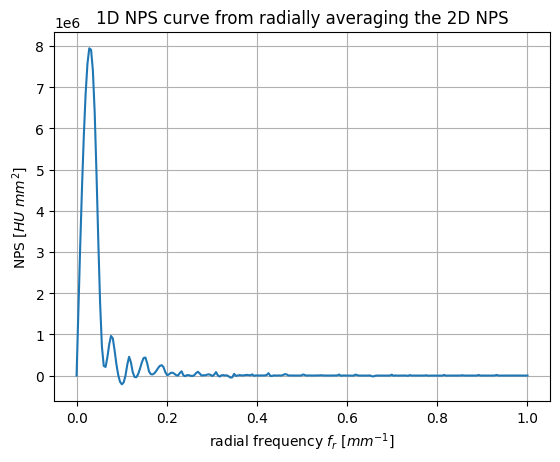

In [16]:
f_r, NPS_1D = calculate_NPS_1D(NPS_2D, 0.402, 64)
plt.plot(f_r, NPS_1D)
plt.xlabel("radial frequency $f_{r}$ $[mm^{-1}]$")
plt.ylabel("NPS [$HU$ $mm^{2}$]")
plt.title("1D NPS curve from radially averaging the 2D NPS")
plt.grid()

### Example of noise assesment using NPS after gaussian filter

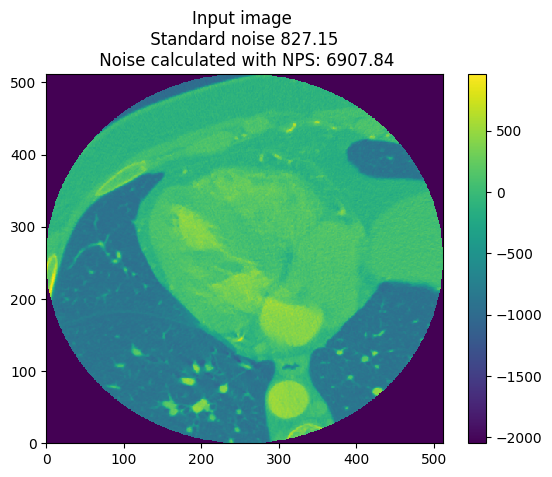

In [17]:
plt.pcolormesh(image)
plt.title(f"Input image \n Standard noise {np.std(image):.2f} \n Noise calculated with NPS: {calculate_sigma(image)[0]:.2f}")
plt.colorbar();

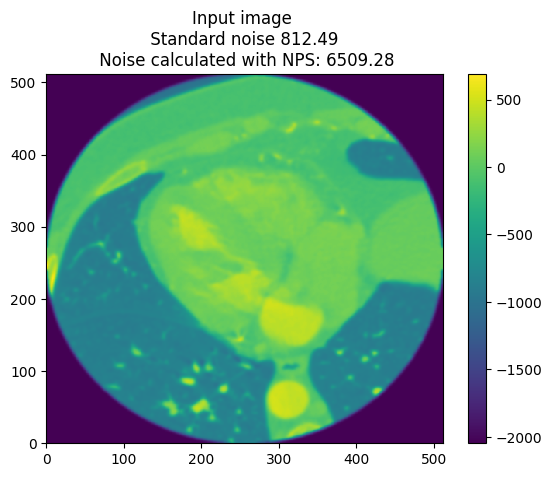

In [18]:
sigma = 2.0
filtered_image = gaussian_filter(image, sigma)
plt.pcolormesh(filtered_image)
plt.title(f"Input image \n Standard noise {np.std(filtered_image):.2f} \n Noise calculated with NPS: {calculate_sigma(filtered_image)[0]:.2f}")
plt.colorbar();

### External link
- https://vciba.springeropen.com/articles/10.1186/s42492-021-00087-9
- https://www.sciencedirect.com/science/article/pii/S1120179715003294
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0271724
- https://journals.sagepub.com/doi/abs/10.1093/jicru_ndt002